In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/data/user/jbourbeau/metaprojects/icerec/V05-00-00/build/lib',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/pyth

In [2]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import radviz
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier

import composition as comp

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
sns.set_palette('muted')
sns.set_color_codes()

In [4]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print(feature_list)
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:105: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125']
number training events = 73257


In [15]:
radviz?

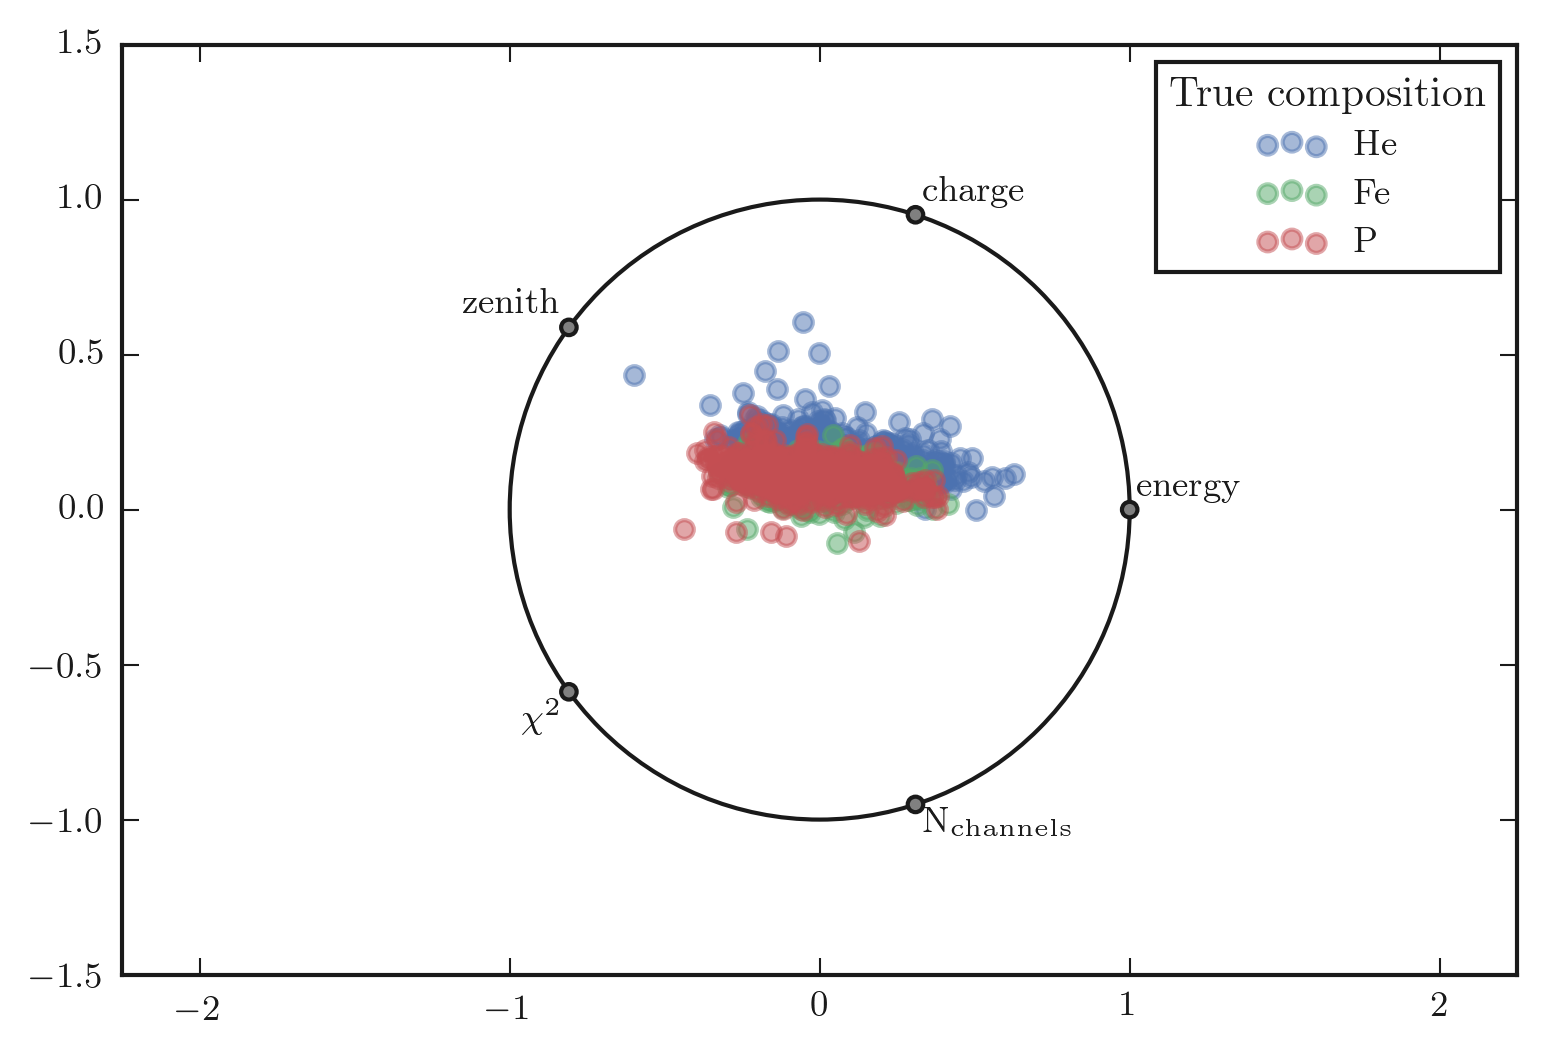

In [6]:
plt.figure()
feature_list = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'lap_chi2', 'log_NChannels_1_30']
tmp = df[feature_list+['MC_comp']]
tmp.columns = ['energy', 'charge', 'zenith', '$\chi^2$', '$\mathrm{N}_{\mathrm{channels}}$', 'comp']
opts = {'alpha': 0.5}
radviz(tmp.sample(2000), 'comp', color=['b', 'g', 'r'], **opts)
plt.legend(title='True composition')

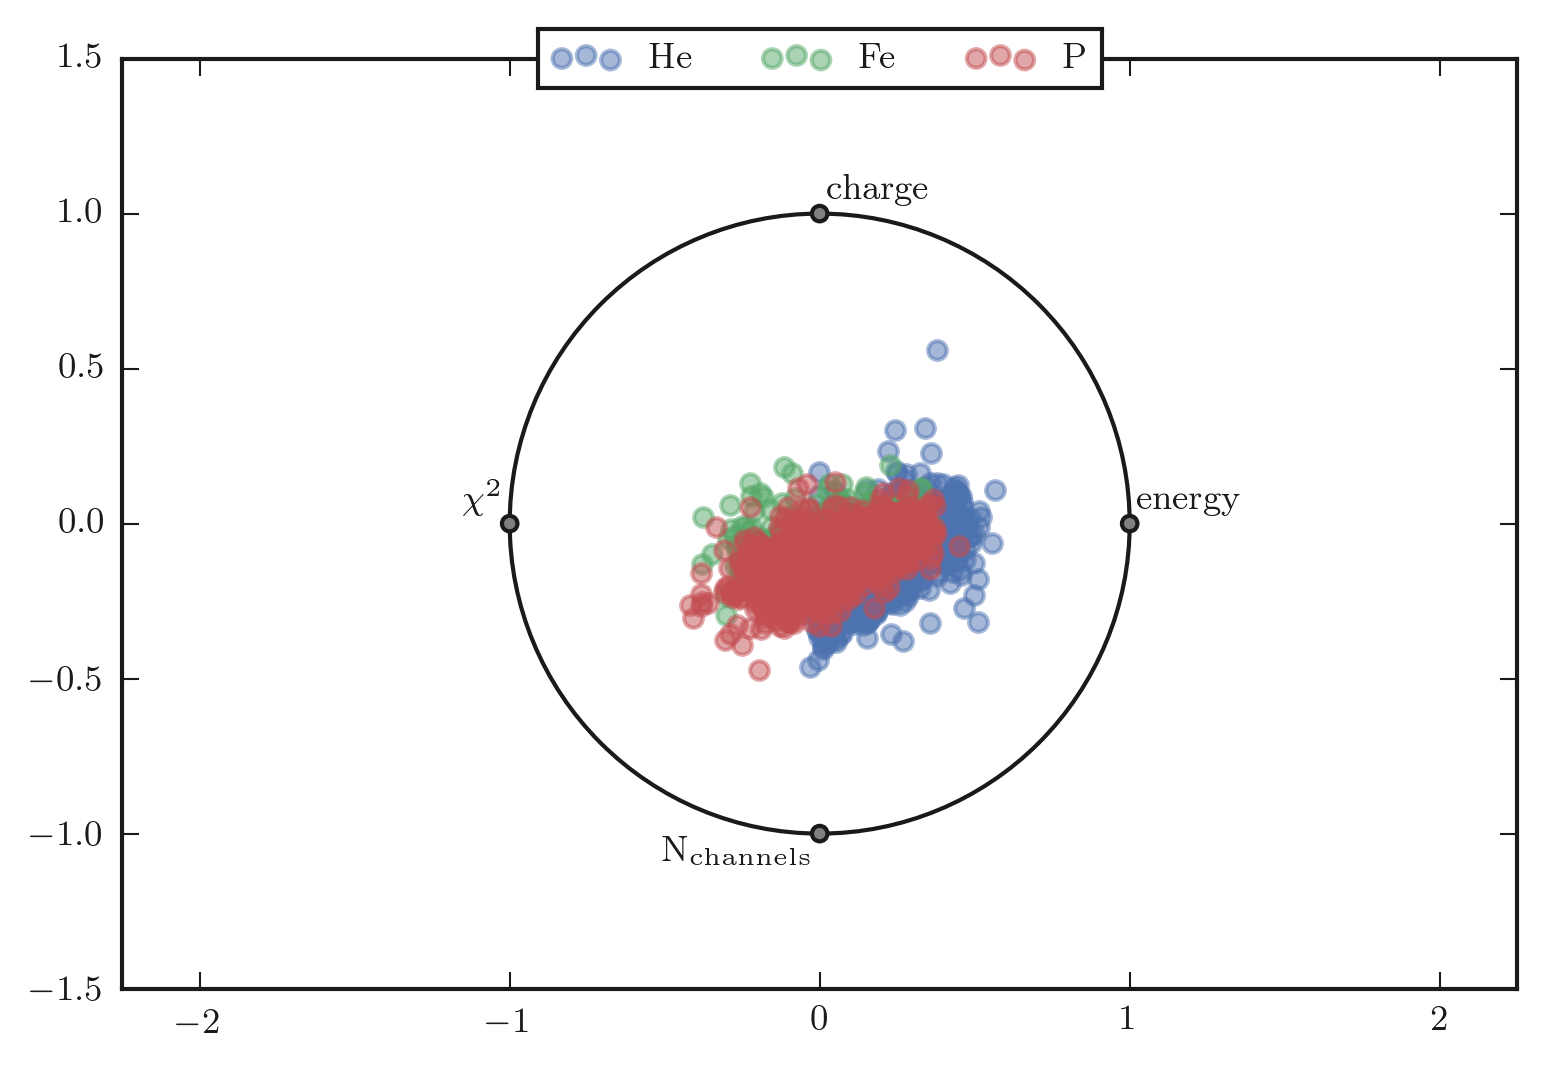

In [17]:
fig, ax = plt.subplots()
feature_list = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_chi2', 'log_NChannels_1_30']
tmp = df[feature_list+['MC_comp']]
tmp.columns = ['energy', 'charge', '$\chi^2$', '$\mathrm{N}_{\mathrm{channels}}$', 'comp']
opts = {'alpha': 0.5}
radviz(tmp.sample(5000), 'comp', color=['b', 'g', 'r'], ax=ax, **opts)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=False, shadow=False)
ax.set_xlim([-1.5, 1.5])
# ax.set_ylim([-1.5, 1.5])
plt.show()

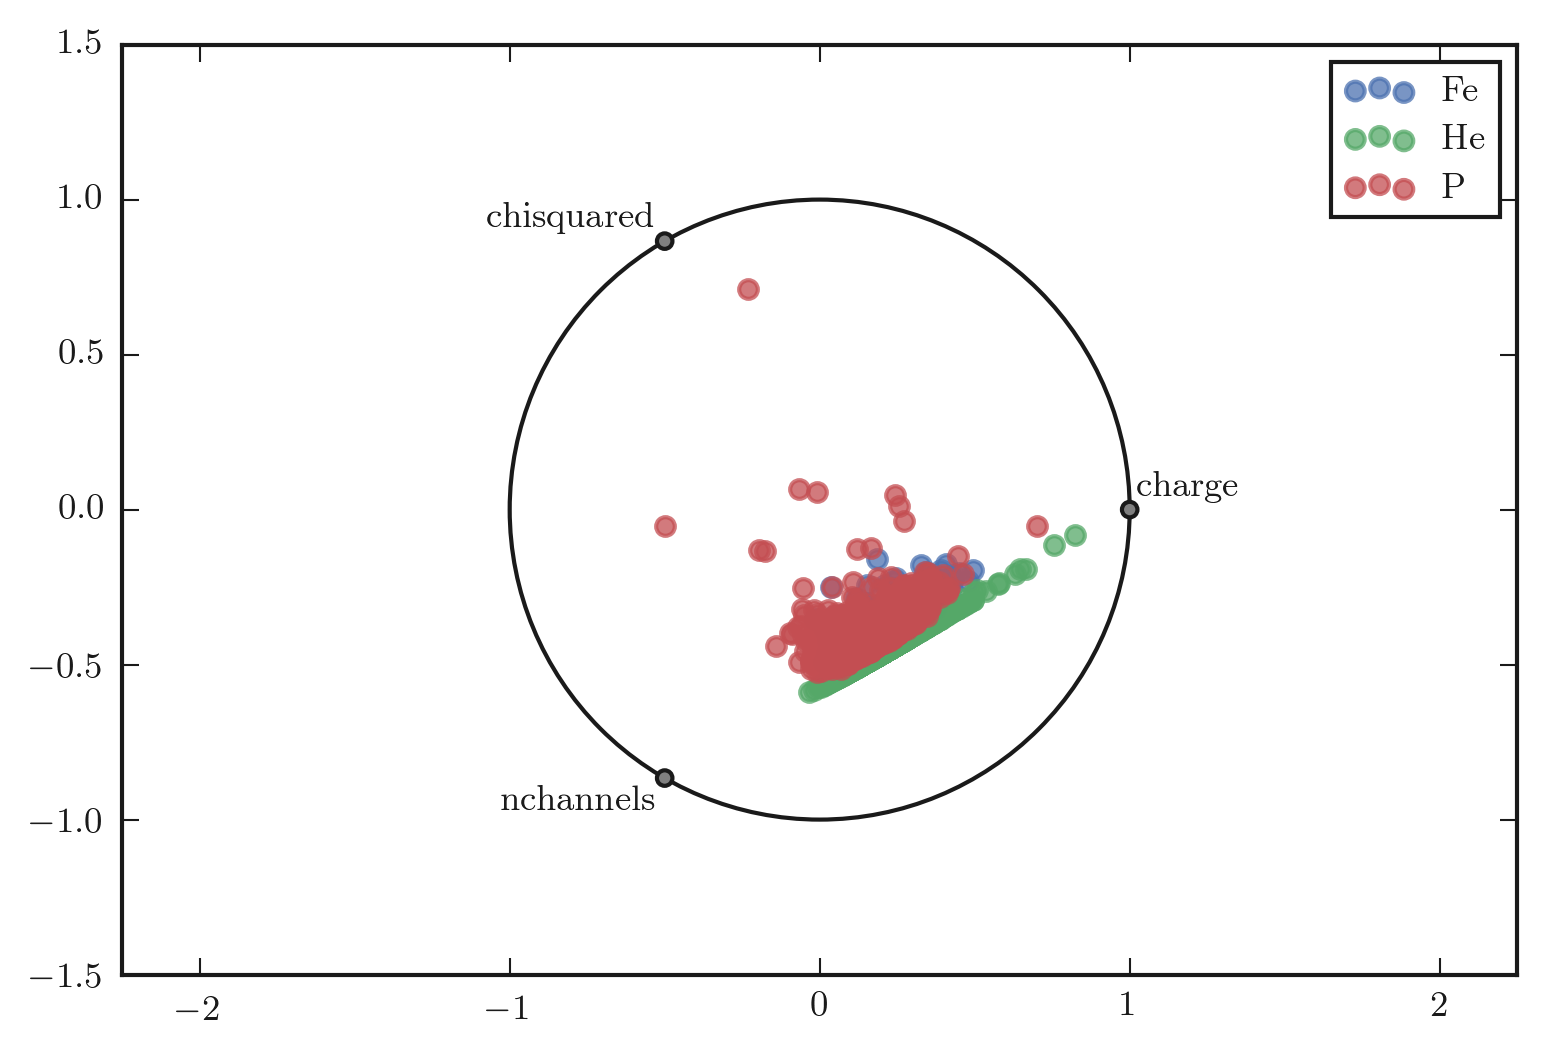

In [22]:
plt.figure()
feature_list = ['InIce_log_charge_1_30', 'lap_chi2', 'log_NChannels_1_30']
tmp = df[feature_list+['MC_comp']]
tmp.columns = ['charge', 'chisquared', 'nchannels','comp']
opts = {'alpha': 0.75}
radviz(tmp.sample(10000), 'comp', color=['b', 'g', 'r'], **opts)

In [24]:
feature_list = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'lap_chi2', 'log_NChannels_1_30']
tmp = df[feature_list+['MC_comp']]
tmp.columns = ['energy', 'charge', 'zenith', 'chisquared', 'nchannels', 'comp']
tmp.sample(frac=1)

,energy,charge,zenith,chisquared,nchannels,comp
410625,6.397034,2.582136,0.903370,0.018033,1.556303,He
150495,6.989937,3.040066,0.998077,0.459173,2.212188,Fe
168491,6.375964,2.810805,0.876818,1.077457,1.612784,Fe
310862,6.777805,2.582845,0.977905,0.018323,1.662758,He
477876,7.157385,3.282042,0.930907,0.015347,2.120574,He
202219,7.828750,3.303651,0.905371,1.051695,2.041393,Fe
65381,6.451769,2.437444,0.974462,0.536076,1.954243,P
9738,6.248129,2.613261,0.977961,0.962385,1.819544,P
460497,7.750908,3.392241,0.967225,0.004413,1.991226,He
225685,6.417087,3.057016,0.909740,0.529079,2.000000,Fe


In [15]:
small.columns = ['energy', 'charge', 'zenith', 'chisquared', 'nchannels', 'comp']

In [16]:
small

,energy,charge,zenith,chisquared,nchannels,comp
1,7.725,3.051990,0.964200,0.561476,109,P
9,7.675,3.295126,0.962817,0.384772,176,P
19,7.525,3.579235,0.928059,0.518567,103,P
27,7.575,3.681950,0.928684,0.517789,185,P
49,6.975,2.839009,0.917719,0.615560,99,P
73,6.375,2.062633,0.945604,0.451978,47,P
75,6.425,2.406748,0.947448,0.498216,72,P
77,6.275,2.059584,0.944470,0.557761,68,P
78,6.325,2.519856,0.946402,0.300512,69,P
81,6.275,2.757371,0.945170,1.078451,83,P
